## Training

In [1]:
%env CUDA_LAUNCH_BLOCKING=1
%env TORCH_USE_CUDA_DSA=1

env: CUDA_LAUNCH_BLOCKING=1
env: TORCH_USE_CUDA_DSA=1


In [2]:
import pathlib as pl
import requests

def download_file(dst_path: pl.Path, url: str):
    res = requests.get(url)
    if not res.status_code == 200:
        raise ValueError(f"Failed to download data - Status code:", res.status_code)

    content = res.content
    with open(dst_path, "wb") as f:
        f.write(content)
    

base_data_path = pl.Path('./data/')
tiny_data_url = "http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz"
tiny_data_name = "tiny_nerf_data.npz"

tiny_data_path = base_data_path / tiny_data_name
if not tiny_data_path.exists():
    download_file(tiny_data_path, tiny_data_url)

In [3]:
from torch.utils.data import Dataset
import re
import torch
import json
from torchvision import io
from torchvision.transforms import v2 as transforms
import numpy as np


rgb_digit_pattern = re.compile("r_(?P<digit>\d+).png")


def load_img_paths(imgs_path: pl.Path) -> list[pl.Path]:
    # Ordered lexagraphically, rearrange to numberical ordering
    digit_path_pairs = []
    for path in imgs_path.iterdir():
        name_match = rgb_digit_pattern.match(path.name)
        if not name_match:
            continue

        digit = int(name_match.groupdict()["digit"])
        digit_path_pairs.append((digit, path))

    return [path for _, path in sorted(digit_path_pairs)]


def load_img(
    img_path: pl.Path,
    downsample_factor: int = 1,
    antialias: bool = True,
    interpolation: transforms.InterpolationMode = transforms.InterpolationMode.BICUBIC,
) -> torch.Tensor:
    img = io.read_image(str(img_path), mode=io.ImageReadMode.RGB_ALPHA) / 255.0

    if downsample_factor > 1:
        C, H, W = img.shape
        img = transforms.Resize(
            (H // downsample_factor, W // downsample_factor),
            antialias=antialias,
            interpolation=interpolation,
        )(img)
        img = torch.clamp(img, 0., 1.)

    return img


class FrameDataset(Dataset):
    def __init__(
        self,
        data_path: pl.Path,
        data_mode: str,  # 'train', 'val', 'test'
        ex_idx: int = 0,
        downsample_factor: int = 1,
        antialias: bool = True,
        interpolation: transforms.InterpolationMode = transforms.InterpolationMode.BICUBIC,
        seg_cutoff: float = 2e-2 
    ) -> None:
        super().__init__()
        self.downsample_factor = downsample_factor

        transforms_path = data_path / f"transforms_{data_mode}.json"
        with open(transforms_path, "r") as f:
            transforms = json.load(f)
        self.cam_angle_x = float(transforms["camera_angle_x"])

        self.poses = [
            # Assume ordered
            torch.FloatTensor(frame["transform_matrix"])
            for frame in transforms["frames"]
        ]

        imgs_path = data_path / data_mode
        img_paths = load_img_paths(imgs_path)
        imgs = [
            load_img(img_path, downsample_factor, antialias, interpolation)
            for img_path in img_paths
        ]
        imgs = torch.stack(imgs)[:, :3]
        self.imgs = imgs.permute(0, 2, 3, 1)
        self.segs = (self.imgs.sum(axis=-1) > seg_cutoff).float()

        self.ex_img, *_ = self[ex_idx]
        self.H, self.W, self.C = self.ex_img.shape

        self.focal = 0.5 * self.W / np.tan(0.5 * self.cam_angle_x)

    @property
    def shape(self) -> tuple[int, int]:
        return self.H, self.W

    def __len__(self) -> int:
        return len(self.poses)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        return self.imgs[idx], self.poses[idx], self.segs[idx]

In [4]:
import numpy as np
import matplotlib.pyplot as plt

downscale_factor = 8

data_source_name = "NeRF_Data"
dataset_name = "nerf_synthetic"
scene_name = "lego"

root_data_dir = pl.Path('./data/')
data_path = root_data_dir / data_source_name / dataset_name / scene_name

train_dataset = FrameDataset(data_path, "train", downsample_factor=downscale_factor)
val_dataset = FrameDataset(data_path, "val", downsample_factor=downscale_factor)
test_dataset = FrameDataset(data_path, "test", downsample_factor=downscale_factor)

Data overview
	Number of samples: 100
	Image shape: ((100, 100))
	Poses shape: (torch.Size([100, 100, 3]))
	Focal value: 138.889
	Image range: ((tensor(0.), tensor(1.)))
Pose:
tensor([[ 0.6890,  0.5340, -0.4900, -1.9750],
        [-0.7240,  0.5080, -0.4660, -1.8790],
        [ 0.0000,  0.6760,  0.7370,  2.9700],
        [ 0.0000,  0.0000,  0.0000,  1.0000]])


torch.Size([100, 100, 100, 3])

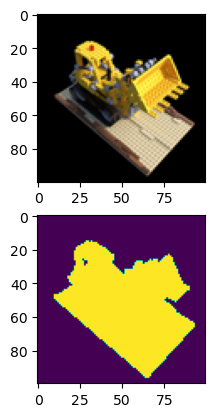

In [5]:
#H, W = imgs.shape[1:3]
H, W = train_dataset.shape

i_ref = 50
ref_img, ref_pose, ref_seg = val_dataset[i_ref]

print("=" * 50)
print("Data overview")
print(f"\tNumber of samples: {len(train_dataset)}")
print(f"\tImage shape: ({train_dataset.shape})")
print(f"\tPoses shape: ({ref_img.shape})")
print(f"\tFocal value: {train_dataset.focal:.3f}")
print(f"\tImage range: ({ref_img.min(), ref_img.max()})")
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.imshow(ref_img)
ax2.imshow(ref_seg)
print("=" * 50)
print("Pose:")
print(np.round(ref_pose, 3))

train_dataset.imgs.shape

In [6]:
import torch
from torch import nn


class NerfSeg(nn.Module):
    def __init__(
        self, name: str, L1: int, L2: int, n_hidden: int, act_func: nn.Module = nn.ReLU
    ) -> None:
        super().__init__()

        self.name = name

        self.d1 = 6 * L1 + 3
        self.d2 = 6 * L2 + 3

        self.stack1 = nn.Sequential(
            nn.Linear(self.d1, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
        )

        self.stack2 = nn.Sequential(
            nn.Linear(n_hidden + self.d1, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden),
            act_func(),
            nn.Linear(n_hidden, n_hidden + 2),
        )

        self.stack3 = nn.Sequential(
            nn.Linear(n_hidden + self.d2, n_hidden // 2),
            act_func(),
            nn.Linear(n_hidden // 2, 3),
        )

    def forward(
        self, o: torch.Tensor, d: torch.Tensor
    ) -> tuple[torch.Tensor, torch.Tensor]:
        x = o

        x = self.stack1(x)
        x = torch.cat((o, x), dim=-1)

        x = self.stack2(x)
        sigma = x[..., 0:1]
        seg = x[..., 1:2]

        x = torch.cat((x[..., 2:], d), dim=-1)
        x = self.stack3(x)
        rgb = x

        y = torch.cat((rgb, sigma, seg), dim=-1)
        return y

In [7]:
import torchvision


class BackpropException(Exception):
    ...


@torch.jit.script
def pos_enc(x: torch.Tensor, L: int) -> torch.Tensor:
    # TODO: Optimimze
    rets = [x]
    for i in range(L):
        z = 2.0**i * x
        rets.append(torch.sin(z))
        rets.append(torch.cos(z))

    return torch.cat(rets, -1)


@torch.jit.script
def positional_encoding(p: torch.Tensor, L: int, device: torch.device) -> torch.Tensor:
    assert len(p.shape) == 3
    assert L % 2 == 0

    B, NB, D = p.shape

    pe = torch.zeros(B, NB, 2 * D * L + D, device=device)
    pe[..., :3] = p
    for i in range(0, L):
        pe[..., 3 + 6 * i : 3 + 6 * i + 3] = torch.sin(2**i * p)
        pe[..., 3 + 6 * i + 3 : 3 + 6 * i + 6] = torch.cos(2**i * p)
    return pe


@torch.jit.script
def get_rays(
    H: int, W: int, focal: float, c2w: torch.Tensor, device: torch.device
) -> tuple[torch.Tensor, torch.Tensor]:
    x = torch.arange(W, dtype=torch.float32, device=device)
    y = torch.arange(H, dtype=torch.float32, device=device)
    i, j = torch.meshgrid(x, y, indexing="xy")
    dirs = torch.stack(
        ((i - W * 0.5) / focal, -(j - H * 0.5) / focal, -torch.ones_like(i)), dim=-1
    )
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
    rays_o = c2w[:3, -1].broadcast_to(rays_d.shape).clone()

    return rays_o, rays_d


@torch.jit.script
def exclusive_cumprod(x: torch.Tensor) -> torch.Tensor:
    x = torch.cumprod(x, -1)
    x = x.roll(1)
    x[..., 0] = 1
    return x


@torch.jit.script
def volume_rendering(
    rgb: torch.Tensor,
    sigma: torch.Tensor,
    seg: torch.Tensor,
    t: torch.Tensor,
    device: torch.device,
):
    delta = torch.diff(
        t,
        dim=-1,
        append=1e10 * torch.ones(t[..., :1].shape, device=device, dtype=torch.float32),
    )
    sigma_delta = torch.exp(-sigma * delta)

    w = (1.0 - sigma_delta) * exclusive_cumprod(sigma_delta + 1e-10)

    rgb_map = torch.sum(w[..., None] * rgb, -2)
    depth_map = torch.sum(w * t, -1)
    seg_map = torch.sum(w * seg, -1)
    seg_map = torch.clip(seg_map, 0.000001, 0.999999)

    return rgb_map, depth_map, seg_map


def render_rays(
    model: nn.Module,
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    t_near: float,
    t_far: float,
    n_samples_per_ray: int,
    L1: int,
    L2: int,
    chunk_size: int,
    device: torch.device,
    use_stratified_sampling: bool = True,
):
    model.eval()
    with torch.no_grad():
        t = (
            torch.linspace(t_near, t_far, n_samples_per_ray, device=device)
            .broadcast_to([*rays_o.shape[:-1], n_samples_per_ray])
            .clone()
        )
        if use_stratified_sampling:
            scalar = (t_far - t_near) / n_samples_per_ray
            offsets = torch.rand([*rays_o.shape[:-1], n_samples_per_ray], device=device)
            t += offsets * scalar

        pts = rays_o[..., None, :] + rays_d[..., None, :] * t[..., :, None]
        dirs = rays_d[..., None, :].broadcast_to(pts.shape)

        x = pts.reshape(-1, 3)
        x = pos_enc(x, L1)
        d = dirs.reshape(-1, 3)
        d = pos_enc(d, L2)

        ys = [
            model(x[i : i + chunk_size], d[i : i + chunk_size])
            for i in range(0, x.size(0), chunk_size)
        ]
        y = torch.cat(tuple(ys), dim=0).reshape([*pts.shape[:-1], ys[0].size(-1)])

        rgb = y[..., :3]
        rgb = nn.functional.sigmoid(rgb)

        sigma = y[..., 3]
        sigma = nn.functional.relu(sigma)

        seg = y[..., 4]
        seg = nn.functional.sigmoid(seg)

        rgb_map, depth_map, seg_map = volume_rendering(rgb, sigma, seg, t, device)

    return rgb_map, depth_map, seg_map


def render_rays_and_train(
    model: nn.Module,
    optim: torch.optim.Optimizer,
    rays_o: torch.Tensor,
    rays_d: torch.Tensor,
    rgb_gt: torch.Tensor,
    seg_gt: torch.Tensor,
    seg_loss_scalar: float,
    t_near: float,
    t_far: float,
    n_samples_per_ray: int,
    grad_clip_val: float,
    L1: int,
    L2: int,
    chunk_size: int,
    device: torch.device,
    use_stratified_sampling: bool = False,
):
    H, W, _ = rays_o.shape
    assert (H * W) % chunk_size == 0

    t = (
        torch.linspace(t_near, t_far, n_samples_per_ray, device=device)
        .broadcast_to((H, W, n_samples_per_ray))
        .clone()
    )
    if use_stratified_sampling:
        t += torch.rand(t.shape, device=device) * (t_far - t_near) / n_samples_per_ray

    pts = rays_o[..., None, :] + rays_d[..., None, :] * t[..., :, None]
    dirs = rays_d[..., None, :].broadcast_to(pts.shape)

    x = pts.reshape(-1, n_samples_per_ray, 3)
    x = positional_encoding(x, L1, device)
    d = dirs.reshape(-1, n_samples_per_ray, 3)
    d = positional_encoding(d, L2, device)

    rgb_gt_flat = rgb_gt.reshape(-1, 3)
    seg_gt_flat = seg_gt.reshape(-1)
    t_flat = t.reshape(-1, n_samples_per_ray)

    loss_rgb = 0
    loss_seg = 0
    loss = 0
    rgb_mean = 0

    for i in range(0, x.size(0), chunk_size):
        optim.zero_grad()

        x_chunk = x[i : i + chunk_size]
        d_chunk = d[i : i + chunk_size]
        rgb_gt_chunk = rgb_gt_flat[i : i + chunk_size]
        seg_gt_chunk = seg_gt_flat[i : i + chunk_size]
        t_chunk = t_flat[i : i + chunk_size]

        y = model(x_chunk, d_chunk).reshape(-1, n_samples_per_ray, 5)

        rgb = y[..., :3]
        rgb = nn.functional.sigmoid(rgb)

        sigma = y[..., 3]
        sigma = nn.functional.relu(sigma)

        seg = y[..., 4]
        seg = nn.functional.sigmoid(seg)

        rgb, sigma, seg = volume_rendering(rgb, sigma, seg, t_chunk, device)

        loss_rgb_chunk = nn.functional.mse_loss(rgb, rgb_gt_chunk)
        loss_seg_chunk = nn.functional.binary_cross_entropy(seg, seg_gt_chunk)

        loss_chunk = loss_rgb_chunk + seg_loss_scalar * loss_seg_chunk
        try:
            loss_chunk.backward()
        except Exception as e:
            raise BackpropException(
                f"rgb_shape: {rgb.shape}, sigma_shape: {sigma.shape}, seg_shape: {seg.shape}, loss_rgb: {loss_rgb}, seg_range: ({seg.min()},{seg.max()}), loss_seg: {loss_seg}, loss: {loss}",
                e,
            )
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip_val)
        optim.step()

        loss_rgb += loss_rgb_chunk.item()
        loss_seg += loss_seg_chunk.item()
        loss += loss_chunk.item()
        rgb_mean += rgb.mean().item()

    n_chunks = H * W // chunk_size
    loss_rgb /= n_chunks
    loss_seg /= n_chunks
    loss /= n_chunks
    rgb_mean /= n_chunks

    return loss_rgb, loss_seg, loss, rgb_mean


def save_rgb_tensor_as_img(x: torch.Tensor, path: pl.Path):
    x = x.detach().cpu().permute(2, 0, 1)
    im = torchvision.transforms.ToPILImage("RGB")(x)
    im.save(path)


def save_mono_tensor_as_img(x: torch.Tensor, path: pl.Path):
    x = x.detach().cpu()
    im = torchvision.transforms.ToPILImage()(x)
    im.save(path)

In [8]:
import time
import shutil


def train_nerf(
    model: nn.Module,
    optim: torch.optim.Optimizer,
    n_iter: int,
    base_model_path: pl.Path,
    train_dataset: Dataset,
    ref_sample: tuple[torch.Tensor, torch.Tensor, torch.Tensor],
    device: torch.device,
    t_near: float,
    t_far: float,
    d_pos_embed: int,
    d_dir_embed: int,
    n_samples_per_ray: int,
    chunk_size: int,
    grad_clip_val: float,
    load_checkpoint_path: pl.Path = None,
    save_freq: int = 20,
    print_epoch: bool = True,
):
    if not base_model_path.exists():
        raise ValueError

    if load_checkpoint_path:
        if not load_checkpoint_path.exists():
            raise ValueError

        checkpoint = torch.load(str(load_checkpoint_path))
        model.load_state_dict(checkpoint["model_state_dict"])
        optim.load_state_dict(checkpoint["optim_state_dict"])
        i_sample = checkpoint["epochs"][-1] + 1

    else:
        checkpoint = {
            "epochs": [],
            "train_loss": [],
            "train_loss_rgb": [],
            "train_loss_seg": [],
            "ref_loss": [],
            "ref_loss_rgb": [],
            "ref_loss_seg": [],
            "model_state_dict": None,
            "optim_state_dict": None,
        }
        i_sample = 0

    model_save_path = base_model_path / model.name
    model_save_path.mkdir(exist_ok=True)

    version = len(list(model_save_path.iterdir()))
    version_path = model_save_path / f"version-{version}"
    version_path.mkdir(exist_ok=False)

    if version_path.exists():
        shutil.rmtree(version_path)

    if not version_path.exists():
        version_path.mkdir()

    ref_rgb, ref_pose, ref_seg = ref_sample

    ref_path = version_path / "ref"
    ref_path.mkdir()
    save_rgb_tensor_as_img(ref_rgb, ref_path / f"rgb.png")
    save_mono_tensor_as_img(ref_seg, ref_path / f"cls.png")

    ref_rgb = ref_rgb.to(device)
    ref_pose = ref_pose.to(device)
    ref_seg = ref_seg.to(device)

    H, W = train_dataset.shape

    ref_rays_o, ref_rays_d = get_rays(
        H, W, train_dataset.focal, ref_pose, device=device
    )

    prev_time = time.time()
    while i_sample <= n_iter:
        i = np.random.randint(len(train_dataset))

        with torch.no_grad():
            rgb_gt, pose, seg_gt = train_dataset[i]
            rgb_gt = rgb_gt.to(device)
            pose = pose.to(device)
            seg_gt = seg_gt.to(device)

            rays_o, rays_d = get_rays(H, W, train_dataset.focal, pose, device=device)

        model.train()
        # try:
        loss_rgb, loss_seg, loss, rgb_mean = render_rays_and_train(
            model,
            optim,
            rays_o,
            rays_d,
            rgb_gt,
            seg_gt,
            seg_loss_scalar,
            t_near,
            t_far,
            n_samples_per_ray,
            grad_clip_val,
            d_pos_embed,
            d_dir_embed,
            chunk_size,
            device=device,
            use_stratified_sampling=use_stratified_sampling,
        )
        # except Exception as e:
        #    print(f"Epoch {i_sample} - Failed on backprop due to exception", e)
        #    i_sample += 1
        #    continue

        if i_sample % save_freq == 0:
            curr_time = time.time()
            model.eval()

            rgb_rp, depth_rp, seg_rp = render_rays(
                model,
                ref_rays_o,
                ref_rays_d,
                t_near,
                t_far,
                n_samples_per_ray,
                d_pos_embed,
                d_dir_embed,
                chunk_size,
                device=device,
                use_stratified_sampling=use_stratified_sampling,
            )
            ref_loss_rgb = nn.functional.mse_loss(rgb_rp, ref_rgb)
            ref_loss_seg = nn.functional.binary_cross_entropy(seg_rp, ref_seg)
            ref_loss = ref_loss_rgb + seg_loss_scalar * ref_loss_seg

            epoch_path = version_path / f"epoch-{i_sample}"
            epoch_path.mkdir()
            checkpoint["epochs"].append(i_sample)
            checkpoint["train_loss"].append(loss)
            checkpoint["train_loss_rgb"].append(loss_rgb)
            checkpoint["train_loss_seg"].append(loss_seg)
            checkpoint["ref_loss"].append(ref_loss)
            checkpoint["ref_loss_rgb"].append(ref_loss_rgb)
            checkpoint["ref_loss_seg"].append(ref_loss_seg)
            checkpoint["model_state_dict"] = model.state_dict()
            checkpoint["optim_state_dict"] = optim.state_dict()
            torch.save(checkpoint, epoch_path / f"checkpoint.cp")

            save_rgb_tensor_as_img(rgb_rp, epoch_path / f"rgb.png")
            save_mono_tensor_as_img(depth_rp, epoch_path / f"depth.png")
            save_mono_tensor_as_img(seg_rp, epoch_path / f"cls.png")

            if print_epoch:
                log_path = version_path / "training.log"
                with open(log_path, "a") as f:
                    f.writelines(
                        [
                            "\n",
                            "=" * 50 + '\n',
                            f"Epoch: {i_sample} / {n_iter}\n",
                            f"Duration / Epoch: {(curr_time - prev_time)/save_freq:.3f}\n",
                            f"Train loss: {loss:.5e}\n",
                            f"Train loss - RGB: {loss_rgb:.5e}\n",
                            f"Train loss - Segmentation: {loss_seg:.5e}\n",
                            f"Ref loss: {ref_loss:.5e}\n",
                            f"Ref loss - RGB: {ref_loss_rgb:.5e}\n",
                            f"Ref loss - Segmentation: {ref_loss_seg:.5e}\n",
                            f"Mean outout: {rgb_mean:.5f}\n",
                            "\n"
                        ]
                    )

            prev_time = time.time()

        i_sample += 1



n_samples_per_ray = 128
n_hidden = 256
d_pos_embed = 10
d_dir_embed = 4
t_near = 2.0
t_far = 6.0

lr = 3e-4
chunk_size = 1000
grad_clip_val = 2.0
#seg_loss_scalar = 5e-4
seg_loss_scalar = 0
n_iter = 1321

use_stratified_sampling = True
save_freq = 20

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "nerf-seg"
model = NerfSeg(
    model_name, L1=d_pos_embed, L2=d_dir_embed, n_hidden=n_hidden, act_func=nn.ReLU
).to(device)
optim = torch.optim.Adam(model.parameters(), lr=lr)

base_model_path = pl.Path("./models")



TRAIN_MODEL = True
if TRAIN_MODEL:
    train_nerf(
        model=model,
        optim=optim,
        n_iter=n_iter,
        base_model_path=base_model_path,
        train_dataset=train_dataset,
        ref_sample=(ref_img, ref_pose, ref_seg),
        device=device,
        t_near=t_near,
        t_far=t_far,
        d_pos_embed=d_pos_embed,
        d_dir_embed=d_dir_embed,
        n_samples_per_ray=n_samples_per_ray,
        chunk_size=chunk_size,
        grad_clip_val=grad_clip_val,
        save_freq=save_freq,
        #load_checkpoint_path=pl.Path('models/nerf-seg/version-3/epoch-760/checkpoint.cp')
    )

: 

In [9]:
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\gaspa\appdata\local\temp\pip-req-build-d4qkk1ay
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36830 sha256=0886319bfc11c2feb7bb2b2c10776efd337b0b2bb3155170b90a9a05718c8b44
  Stored in directory: C:\Users\gaspa\AppData\Local\Temp\pip-ephem-wheel-cache-8_1tb0b9\wheels\15\d7\bd\05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment-anything


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\gaspa\AppData\Local\Temp\pip-req-build-d4qkk1ay'


In [114]:
USE_SAM = False


if USE_SAM:
    sam_model_cp_url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
    sam_model_cp_path = pl.Path('data/sam_vit_h_4b8939.pth')
    if not sam_model_cp_path.exists():
        download_file(sam_model_cp_path, sam_model_cp_url)


    from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

    sam = sam_model_registry["vit_h"](checkpoint=sam_model_cp_path).to(device)
    predictor = SamPredictor(sam)
    mask_generator = SamAutomaticMaskGenerator(sam)

In [115]:
if USE_SAM:
    ex_img = (ref_img*255).long().numpy().astype(np.uint8)
    predictor.set_image(ex_img)
    masks, _, _ = predictor.predict()
    nfig = int(np.ceil(np.sqrt(len(masks))))
    fig, axes = plt.subplots(nfig, nfig)
    for i in range(len(masks)):
        ax = axes[i // nfig, i % nfig]
        ax.grid(False)
        ax.imshow(masks[i])

In [116]:
if USE_SAM:
    masks = mask_generator.generate(ex_img)
    nfig = int(np.ceil(np.sqrt(len(masks))))
    fig, axes = plt.subplots(nfig, nfig)
    for i in range(len(masks)):
        ax = axes[i // nfig, i % nfig]
        ax.grid(False)
        ax.imshow(masks[i]["segmentation"])

In [140]:
from torchvision import io

version_path = pl.Path('./saved-models/nerf-seg/version-1/')

cps = {}
ep_last = -1

ref_path = version_path / "ref"
cps["ref"] = {
    "rgb": io.read_image(str(ref_path / "rgb.png")).permute(1, 2, 0),
    "seg": io.read_image(str(ref_path / "cls.png")).permute(1, 2, 0)
}

for epoch_path in version_path.glob('epoch-*'):
    rgb = io.read_image(str(epoch_path / "rgb.png")).permute(1, 2, 0)
    dep = io.read_image(str(epoch_path / "depth.png")).permute(1, 2, 0)
    seg = io.read_image(str(epoch_path / "cls.png")).permute(1, 2, 0)

    cp = torch.load(epoch_path / "checkpoint.cp")
    epoch = cp["epochs"][-1]    

    cps[epoch] = {
        "rgb": rgb,
        "dep": dep,
        "seg": seg
    }
    is_gpuable = lambda v: isinstance(v, torch.Tensor) or isinstance(v, nn.Module) 

    for key, value in cp.items():
        if is_gpuable(value):
            cps[epoch][key] = value.detach().cpu()
        elif isinstance(value, list) and is_gpuable(value[0]):
            cps[epoch][key] = [v.detach().cpu() for v in value]
        else:
            cps[epoch][key] = value

    if epoch > ep_last:
        ep_last = epoch


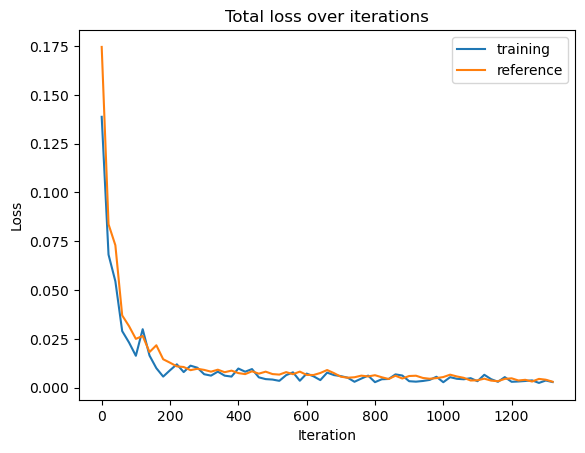

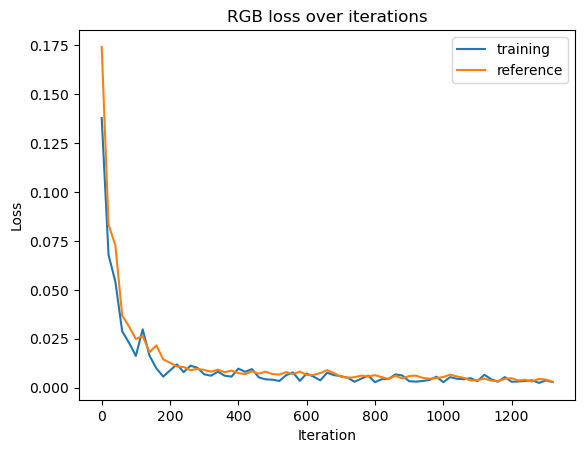

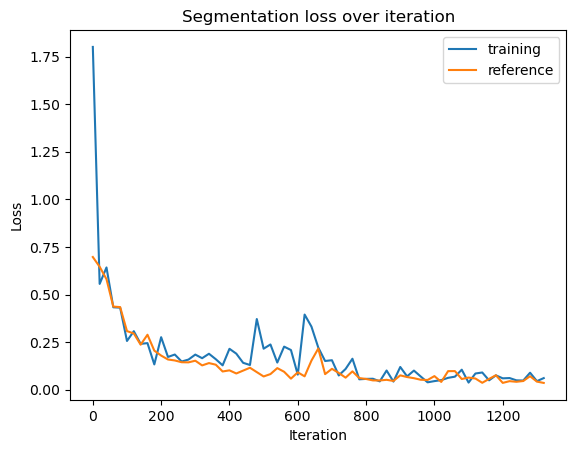

In [137]:
plt.figure()
plt.plot(cps[ep_last]["epochs"], cps[ep_last]["train_loss"], label="training")
plt.plot(cps[ep_last]["epochs"], cps[ep_last]["ref_loss"], label="reference")
plt.xlabel(f"Iteration")
plt.ylabel(f"Loss")
plt.title(f"Total loss over iterations")
plt.legend()

plt.figure()
plt.plot(cps[ep_last]["epochs"], cps[ep_last]["train_loss_rgb"], label="training")
plt.plot(cps[ep_last]["epochs"], cps[ep_last]["ref_loss_rgb"], label="reference")
plt.xlabel(f"Iteration")
plt.ylabel(f"Loss")
plt.title(f"RGB loss over iterations")
plt.legend()

plt.figure()
plt.plot(cps[ep_last]["epochs"], cps[ep_last]["train_loss_seg"], label="training")
plt.plot(cps[ep_last]["epochs"], cps[ep_last]["ref_loss_seg"], label="reference")
plt.xlabel(f"Iteration")
plt.ylabel(f"Loss")
plt.title(f"Segmentation loss over iteration")
plt.legend()

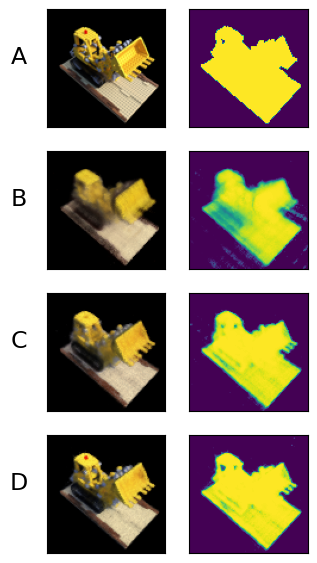

In [241]:
fig, axes = plt.subplots(4, 2, figsize=(3, 6.25))
eps = [440, 880, 1320]
axes[0, 0].imshow(cps["ref"]["rgb"])
axes[0, 1].imshow(cps["ref"]["seg"])
fig.subplots_adjust(0.03, 0.05, 0.98, 0.92, wspace=0)
for i in range(len(eps)):
    ax = axes[i+1]
    ep = eps[i]
    rgb = cps[ep]["rgb"]
    seg = cps[ep]["seg"]
    ax[0].imshow(rgb)
    ax[1].imshow(seg)
    
for ax in axes.flatten():
    ax.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

for i in range(4):
    axes[i, 0].set_ylabel(chr(ord('A')+i), rotation=0, fontsize=17, labelpad=20, fontname='Sans Serif')

In [243]:

def pose_to_image(
    pose, H, W, focal, t_near, t_far, n_samples, L1, L2, chunk_size, model, device
):
    with torch.no_grad():
        rays_o, rays_d = get_rays(
            H, W, focal, pose, device=device
        )
        rgb, depth, seg = render_rays(
            model,
            rays_o,
            rays_d,
            t_near,
            t_far,
            n_samples,
            L1,
            L2,
            chunk_size,
            device=device,
            use_stratified_sampling=True,
        )
    return rgb, depth, seg


def transform_pose(pose: np.ndarray, t: np.ndarray=0, rx: np.ndarray=0, ry: np.ndarray=0, rz: np.ndarray=0):
    pose = np.copy(pose)
    pose[:3, 0] += np.array(rx)
    pose[:3, 1] += np.array(ry)
    pose[:3, 2] += np.array(rz)
    pose[:3, 3] += np.array(t)
    return pose


model = NerfSeg(
    "nerf-seg", L1=d_pos_embed, L2=d_dir_embed, n_hidden=n_hidden, act_func=nn.ReLU
).to(device)
model.load_state_dict(cps[ep_last]["model_state_dict"])
model.requires_grad_(False)
model.eval()
...;

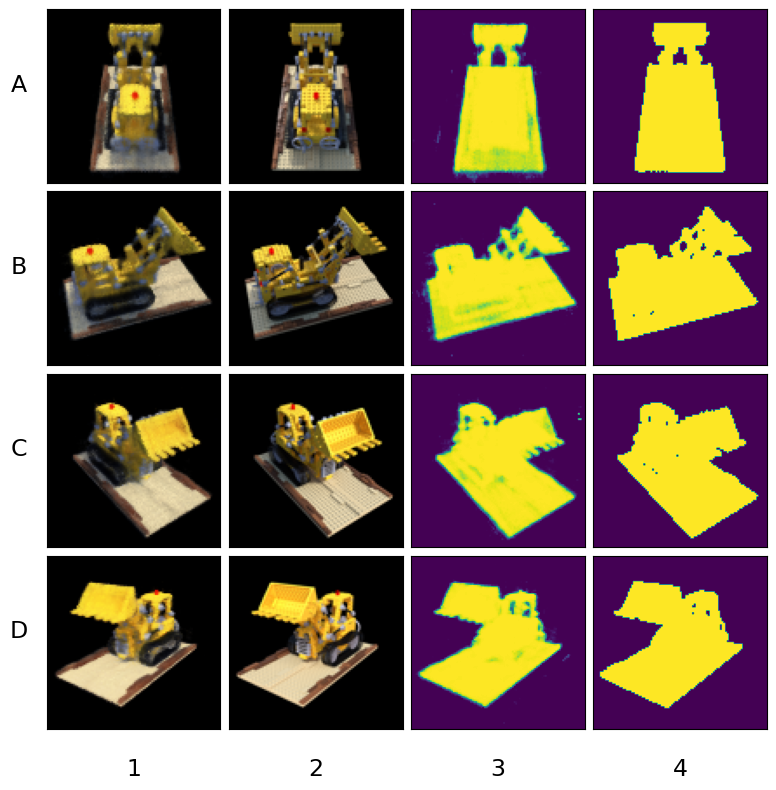

In [254]:
i_sel = [20 * i for i in range(4)]
fig, axes = plt.subplots(len(i_sel), 4, figsize=(8, 2*len(i_sel)))
fig.subplots_adjust(0.05, 0.05, 0.95, 0.95, wspace=0.05, hspace=0.05)


for i in range(len(i_sel)):
    ax = axes[i]

    test_rgb_gt, test_pose, test_seg_gt = test_dataset[i_sel[i]]
    test_rgb_gt = test_rgb_gt.to(device)
    test_pose = test_pose.to(device)
    test_seg_gt = test_seg_gt.to(device)

    test_rgb, test_dep, test_seg = pose_to_image(test_pose, H, W, test_dataset.focal, t_near, t_far, n_samples_per_ray, d_pos_embed, d_dir_embed, chunk_size, model, device)
    ax[0].imshow(test_rgb.cpu())
    ax[1].imshow(test_rgb_gt.cpu())
    ax[2].imshow(test_seg.cpu())
    ax[3].imshow(test_seg_gt.cpu())

for ax in axes.flatten():
    ax.tick_params(axis="both", which="both", bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

for i in range(len(i_sel)):
    axes[i, 0].set_ylabel(chr(ord('A')+i), rotation=0, fontsize=17, labelpad=20, fontname='Sans Serif')

for i in range(4):
    axes[-1, i].set_xlabel(i+1, rotation=0, fontsize=17, labelpad=20, fontname='Sans Serif')

In [268]:
import torchmetrics
import tqdm


ssim_mod = torchmetrics.image.StructuralSimilarityIndexMeasure().to(device)
psnr_mod = torchmetrics.image.PeakSignalNoiseRatio().to(device)
lpips_mod = torchmetrics.image.LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

ssim_acc = 0
psnr_acc = 0
lpips_acc = 0

i_samples = torch.arange(0, len(test_dataset), 10)

with torch.no_grad():
    for i in tqdm.tqdm(i_samples):
        test_rgb_gt, test_pose, test_seg_gt = test_dataset[i]
        test_rgb_gt = test_rgb_gt.to(device)
        test_pose = test_pose.to(device)
        test_seg_gt = test_seg_gt.to(device)

        test_rgb, test_dep, test_seg = pose_to_image(test_pose, H, W, test_dataset.focal, t_near, t_far, n_samples_per_ray, d_pos_embed, d_dir_embed, chunk_size, model, device)

        rgb_gt = test_rgb_gt.permute(2, 0, 1)[None, ...]
        rgb = test_rgb.permute(2, 0, 1)[None, ...]

        ssim = ssim_mod(rgb_gt, rgb)
        psnr = psnr_mod(rgb_gt, rgb)
        lpips = lpips_mod(rgb_gt, rgb)

        ssim_acc += ssim.item()
        psnr_acc += psnr.item()
        lpips_acc += lpips.item()

ssim_tot = ssim_acc / len(test_dataset)
psnr_tot = psnr_acc / len(test_dataset)
lpips_tot = lpips_acc / len(test_dataset)

100%|██████████| 20/20 [01:07<00:00,  3.40s/it]


In [269]:
print(f"SSIM: {ssim_tot}")
print(f"PSNR: {psnr_tot}")
print(f"LPIPS: {lpips_tot}")

SSIM: 0.08668642938137054
PSNR: 2.455573081970215
LPIPS: 0.011061954684555531
